# 1. Парсинг данных

Для проведения кластерного анализа необходимо извлечь следующие исторические даные:
- исторические данные наблюдений движения цены;
- финансовые показатели компаний за историю наблюдений.

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 50)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook

import requests
import apimoex

### Импорт пользовательской библиотеки

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

# setting path
sys.path.append('..')

# importing
from my_lib import *

In [4]:
def ts_first_view(df):
    ticker = df['SECID'][0]
    print(f'####################################################################')
    print(f'_________________________{ticker}___________________________________')
    print(f'####################################################################')
    display(df.head(3))
    display(df.tail(3))
    plot_data(df['CLOSE'], title=f'График цены {ticker}')
    
    plot_timeStamps(df['CLOSE'])

## 1.1 Формирование списка активов

Список ценных бумаг (активов), допущенных к торгам на MOEX можем получить на сайте MOEX по ссылке 
- https://www.moex.com/ru/listing/securities-list.aspx?pageNumber=1

In [5]:
# Загружаем данные
columns = ['DATESTAMP', 'INSTRUMENT_ID', 'LIST_SECTION', 'SUPERTYPE', 'INSTRUMENT_TYPE' , 'TRADE_CODE', 'EMITENT_FULL_NAME']
df_tikers = pd.read_csv('../data/Export_ru_securities-list_20240305.csv', sep=';',usecols=columns, 
                    encoding='cp1251')
           
df_tikers.head()

,DATESTAMP,INSTRUMENT_ID,LIST_SECTION,SUPERTYPE,INSTRUMENT_TYPE,TRADE_CODE,EMITENT_FULL_NAME
0,04.03.2024 00:00:00,15348,Первый уровень,Облигации,Облигация биржевая,NaN,"""Газпромбанк"" (Акционерное общество)"
1,04.03.2024 00:00:00,15349,Первый уровень,Облигации,Облигация биржевая,NaN,"""Газпромбанк"" (Акционерное общество)"
2,04.03.2024 00:00:00,15350,Первый уровень,Облигации,Облигация биржевая,NaN,"""Газпромбанк"" (Акционерное общество)"
3,04.03.2024 00:00:00,15351,Первый уровень,Облигации,Облигация биржевая,NaN,"""Газпромбанк"" (Акционерное общество)"
4,04.03.2024 00:00:00,14052,Первый уровень,Облигации,Облигация биржевая,RU000A101Z74,"""Газпромбанк"" (Акционерное общество)"


Нас интересуют Акции и Депозитарные расписки Первого уровня листинга

In [6]:
# Формируем требуемую подвыборку
cond = (df_tikers['SUPERTYPE'].isin( ['Акции', 'Депозитарные расписки'])) & (df_tikers['LIST_SECTION'] == 'Первый уровень' ) 
df_tikers = df_tikers[cond]

display(df_tikers.head())
display(df_tikers.info())

,DATESTAMP,INSTRUMENT_ID,LIST_SECTION,SUPERTYPE,INSTRUMENT_TYPE,TRADE_CODE,EMITENT_FULL_NAME
11,04.03.2024 00:00:00,5771,Первый уровень,Акции,Акция обыкновенная,CBOM,"""МОСКОВСКИЙ КРЕДИТНЫЙ БАНК"" (публичное акционе..."
18,04.03.2024 00:00:00,16192,Первый уровень,Депозитарные расписки,Депозитарные расписки иностранного эмитента на...,CIAN,Cian PLC (эмитент депозитарных расписок - The ...
19,04.03.2024 00:00:00,12741,Первый уровень,Депозитарные расписки,Депозитарные расписки иностранного эмитента на...,ETLN,ETALON GROUP PLC (эмитент депозитарных расписо...
20,04.03.2024 00:00:00,14953,Первый уровень,Депозитарные расписки,Депозитарные расписки иностранного эмитента на...,FIXP,FIX PRICE GROUP PLC (эмитент депозитарных расп...
21,04.03.2024 00:00:00,12740,Первый уровень,Депозитарные расписки,Депозитарные расписки иностранного эмитента на...,GLTR,Globaltrans Investment PLC (эмитент депозитарн...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 11 to 689
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DATESTAMP          66 non-null     object
 1   INSTRUMENT_ID      66 non-null     int64 
 2   LIST_SECTION       66 non-null     object
 3   SUPERTYPE          66 non-null     object
 4   INSTRUMENT_TYPE    66 non-null     object
 5   TRADE_CODE         66 non-null     object
 6   EMITENT_FULL_NAME  66 non-null     object
dtypes: int64(1), object(6)
memory usage: 4.1+ KB


None

На выходе имеем 66 записей. 
Составим список тикеров из столбца **TRADE_CODE**

In [7]:
# Проверка
tickers_list = list(df_tikers['TRADE_CODE'])
print('Длина полученного списка:', len(tickers_list), 'шт.')
print('Первые пять элементов списка:', tickers_list[:5])

Длина полученного списка: 66 шт.
Первые пять элементов списка: ['CBOM', 'CIAN', 'ETLN', 'FIXP', 'GLTR']


## 1.2 Парсинг исторических данных

#### Выгрузим историю наблюдений индекса Мосбиржи (тикер 'IMOEX')

Взглянем на выгруженные данные:

####################################################################
_________________________IMOEX___________________________________
####################################################################


,BOARDID,CLOSE,VOLUME,VALUE,SECID
TRADEDATE,,,,,
1997-09-22,SNDX,100.00,None,NaN,IMOEX
1997-09-23,SNDX,100.67,None,NaN,IMOEX
1997-09-24,SNDX,99.94,None,NaN,IMOEX


,BOARDID,CLOSE,VOLUME,VALUE,SECID
TRADEDATE,,,,,
2024-03-05,SNDX,3300.89,None,6.618593e+10,IMOEX
2024-03-06,SNDX,3310.58,None,4.942540e+10,IMOEX
2024-03-07,SNDX,3315.68,None,4.234289e+10,IMOEX


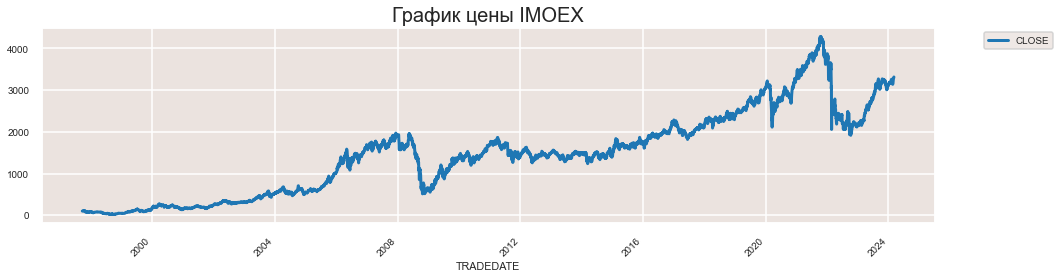

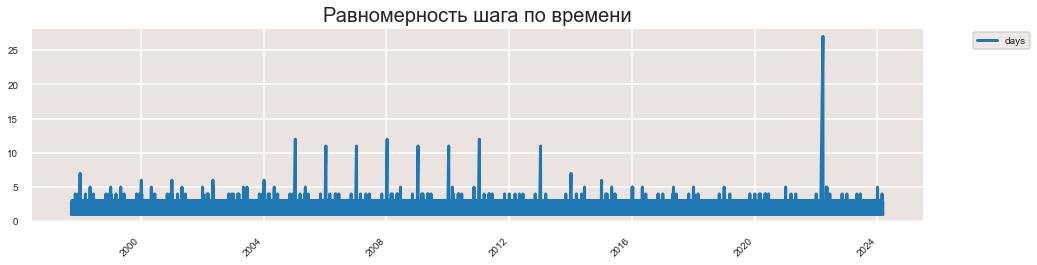

In [8]:
data = pd.read_pickle(f'../data/parsing/ticker_IMOEX.pkl')
ts_first_view(data)

В результате удалось получить исторические данные по IMOEX с 1997 года.

#### Выгрузим историю наблюдений по отобранным акциям

Подготовим функцию извлечения данных для конкретного тикера

In [9]:
def get_history (TICKER, start_date):
    # Функция выгрузки данных по тикеру
    df = pd.DataFrame()
    for i in tqdm_notebook(range(200), desc=TICKER):
        for i in range(3):
            try:
                j = requests.get(f'http://iss.moex.com/iss/history/engines/stock/markets/shares/securities/{TICKER}/candles.json?from={start_date}&till=2024-09-01&interval=24&start=0').json()
                data = [{k : r[i] for i, k in enumerate(j['history']['columns'])} for r in j['history']['data']]
                frame = pd.DataFrame(data)
                df = pd.concat([df, frame[:-1]])
                break
            except:
                # Иначе, пробуем еще несколько раз, пока не закончатся попытки
                print(f'AHTUNG! Ошибка получения данных по {TICKER}: на дату:', start_date)
                continue
            time.sleep(0.3)

        if frame['TRADEDATE'][-1:].values[0] != start_date:
            start_date = frame['TRADEDATE'][-1:].values[0]
        else: break
    
    df.reset_index(drop=True, inplace=True)
    return df

Извлекаем данные по списку тикеров и сохраняем в отдельных файлах типа .pkl с пометкой '_raw'

Посмотрим на пример извлеченных данных:

In [10]:
data = pd.read_pickle(f'../data/parsing/raw/ticker_SBER_raw.pkl')
display(data.head())
display(data.tail())

,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,WAPRICE,CLOSE,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION,CURRENCYID,TRENDCLSPR
0,EQBR,2011-11-21,Сбербанк,SBER,128096,2.283014e+10,79.00,75.85,79.37,76.00,77.71,75.99,293803290,77.71,77.71,77.71,2.283016e+10,2.283016e+10,22830163222.09,None,3,SUR,-5.05
1,SMAL,2011-11-21,Сбербанк,SBER,56,2.539949e+04,79.49,74.50,79.49,75.44,76.27,74.50,333,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.0,None,3,SUR,-7.45
2,EQBR,2011-11-22,Сбербанк,SBER,126144,2.091095e+10,76.40,75.10,77.76,76.08,76.71,76.40,272599350,76.71,76.71,76.71,2.091103e+10,2.091103e+10,20911030041.549999,None,3,SUR,0.54
3,SMAL,2011-11-22,Сбербанк,SBER,50,8.413835e+04,73.20,73.20,77.69,75.97,76.14,76.45,1105,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.0,None,3,SUR,2.62
4,EQBR,2011-11-23,Сбербанк,SBER,140160,2.556061e+10,75.00,74.42,77.44,76.71,76.21,76.80,335403030,76.21,76.21,76.21,2.556062e+10,2.556062e+10,25560621645.84,None,3,SUR,0.52


,BOARDID,TRADEDATE,SHORTNAME,SECID,NUMTRADES,VALUE,OPEN,LOW,HIGH,LEGALCLOSEPRICE,WAPRICE,CLOSE,VOLUME,MARKETPRICE2,MARKETPRICE3,ADMITTEDQUOTE,MP2VALTRD,MARKETPRICE3TRADESVALUE,ADMITTEDVALUE,WAVAL,TRADINGSESSION,CURRENCYID,TRENDCLSPR
8662,TQBR,2024-03-05,Сбербанк,SBER,103489,1.248892e+10,299.33,297.57,300.41,298.70,299.07,298.40,41756340,299.14,299.14,None,1.145410e+10,1.145410e+10,None,0,3,SUR,-0.26
8663,SMAL,2024-03-06,Сбербанк,SBER,29,2.527941e+04,299.98,295.60,299.98,NaN,298.16,297.58,85,NaN,NaN,None,0.000000e+00,0.000000e+00,None,0,3,SUR,-0.80
8664,TQBR,2024-03-06,Сбербанк,SBER,39646,5.293866e+09,298.20,296.82,299.33,298.15,298.16,297.71,17756170,298.16,298.16,None,4.707375e+09,4.707375e+09,None,0,3,SUR,-0.23
8665,SMAL,2024-03-07,Сбербанк,SBER,25,1.967862e+04,298.49,297.51,299.50,NaN,298.84,299.50,66,NaN,NaN,None,0.000000e+00,0.000000e+00,None,0,3,SUR,0.65
8666,SMAL,2024-03-07,Сбербанк,SBER,25,1.967862e+04,298.49,297.51,299.50,NaN,298.84,299.50,66,NaN,NaN,None,0.000000e+00,0.000000e+00,None,0,3,SUR,0.65


Видим наличие проблемы уникальности цены на дату отсчета - в настоящий момент на одну и туже дату имеется несколько значений цены. Это связано с наличием разных режимов торгов (признак **'BOARDID'**). Более того в разные периоды исторических данных менялись обозначения режимов торгов (см. рисунок ниже)

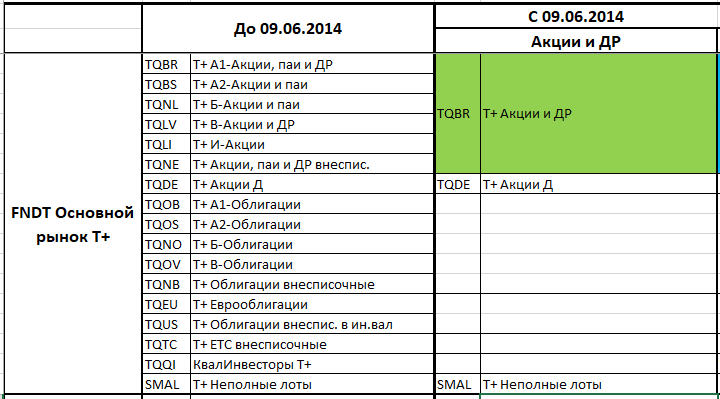

Проведем предобработку данных для дальнейшего использования.

In [11]:
for ticker in tqdm_notebook(tickers_list, desc='tickers', leave=False):
    
    # Загрузка данных по индексу
    data = pd.read_pickle(f'../data/parsing/raw/ticker_{ticker}_raw.pkl')
    data = data.dropna(subset=['CLOSE'])
    
    # Отбор цены закрытия в момент времени по режимам торгов
    max_NUMTRADES = data.groupby(by=['TRADEDATE'])[['NUMTRADES']].max()
    data['CLOSE_NEW'] = data.apply(lambda x: x['CLOSE'] \
                                   if x['NUMTRADES']==max_NUMTRADES['NUMTRADES'][x['TRADEDATE']] else None, axis=1)
    data = data.dropna(subset=['CLOSE_NEW'])
    data = data.dropna(subset=['LEGALCLOSEPRICE'])
    
    # Очистка от полных дубликатов
    data.drop_duplicates(inplace=True)
    data = data[['TRADEDATE', 'SHORTNAME', 'SECID', 'CLOSE_NEW', 'LEGALCLOSEPRICE']]
    data.columns = ['TRADEDATE', 'SHORTNAME', 'SECID', 'CLOSE', 'LEGALCLOSEPRICE']
    data.reset_index(drop=True, inplace=True)
    
    # Преобразование типа данных для дат
    data['TRADEDATE'] = pd.to_datetime(data['TRADEDATE'], 
                                       format='%Y-%m-%d', 
                                       errors='coerce')
    data.index= data['TRADEDATE']
    data.drop(columns=['TRADEDATE', 'LEGALCLOSEPRICE'], inplace=True)
    
    # Сохранение очищенного сформированного датасета по тикеру
    data.to_pickle(f'../data/parsing/ticker_{ticker}.pkl')

tickers:   0%|          | 0/66 [00:00<?, ?it/s]

Посмотрим на очищенные данные:

####################################################################
_________________________SBER___________________________________
####################################################################


,SHORTNAME,SECID,CLOSE
TRADEDATE,,,
2011-11-21,Сбербанк,SBER,75.99
2011-11-22,Сбербанк,SBER,76.40
2011-11-23,Сбербанк,SBER,76.80


,SHORTNAME,SECID,CLOSE
TRADEDATE,,,
2024-03-04,Сбербанк,SBER,299.17
2024-03-05,Сбербанк,SBER,298.40
2024-03-06,Сбербанк,SBER,297.71


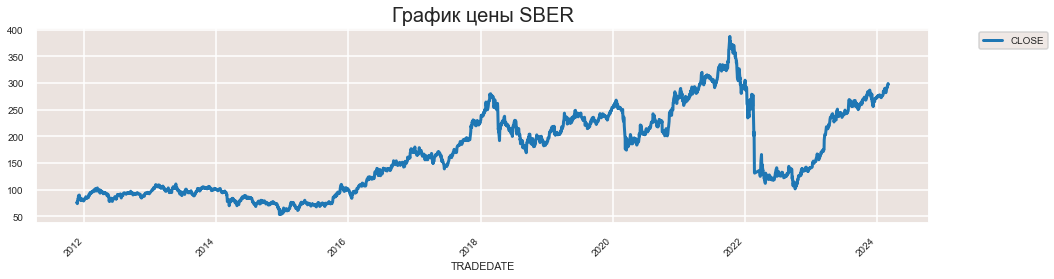

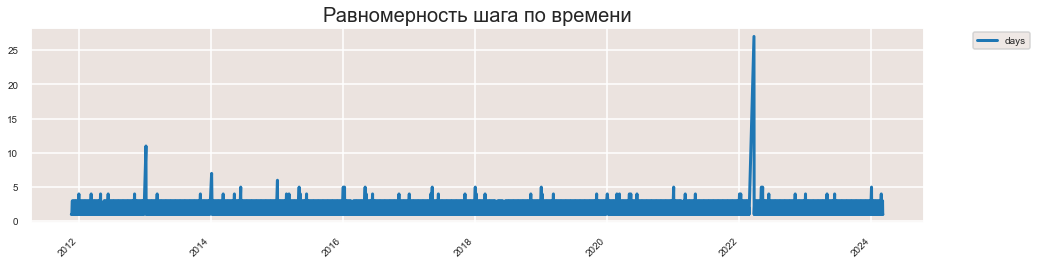

In [12]:
data = pd.read_pickle(f'../data/parsing/ticker_SBER.pkl')
ts_first_view(data)

####################################################################
_________________________YNDX___________________________________
####################################################################


,SHORTNAME,SECID,CLOSE
TRADEDATE,,,
2014-06-04,Yandex clA,YNDX,1170.0
2014-06-05,Yandex clA,YNDX,1145.1
2014-06-06,Yandex clA,YNDX,1163.0


,SHORTNAME,SECID,CLOSE
TRADEDATE,,,
2024-03-04,Yandex clA,YNDX,3700.6
2024-03-05,Yandex clA,YNDX,3627.0
2024-03-06,Yandex clA,YNDX,3577.8


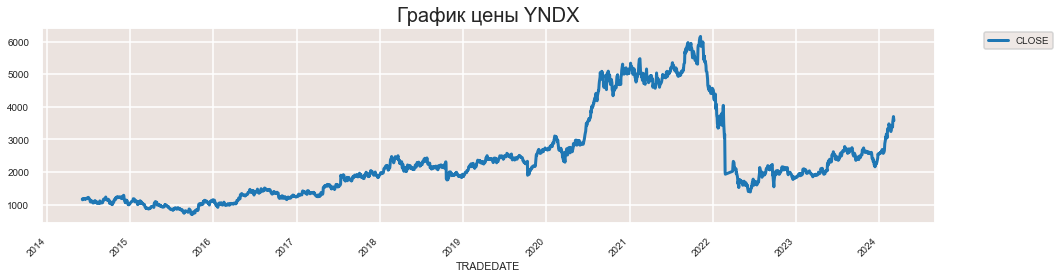

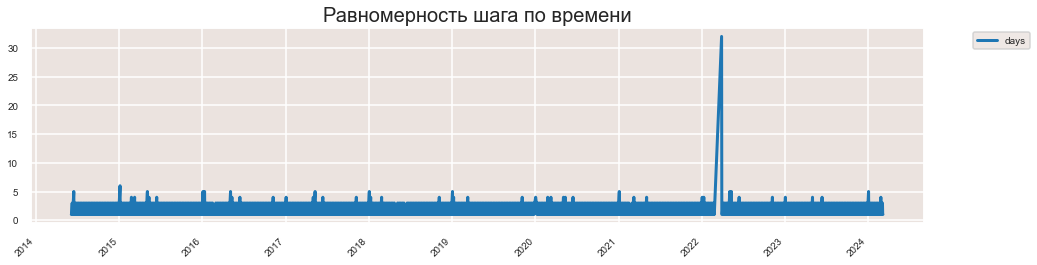

In [13]:
data = pd.read_pickle(f'../data/parsing/ticker_YNDX.pkl')
ts_first_view(data)

####################################################################
_________________________GAZP___________________________________
####################################################################


,SHORTNAME,SECID,CLOSE
TRADEDATE,,,
2006-01-23,ГАЗПРОМ ао,GAZP,218.89
2006-01-24,ГАЗПРОМ ао,GAZP,224.00
2006-01-25,ГАЗПРОМ ао,GAZP,228.38


,SHORTNAME,SECID,CLOSE
TRADEDATE,,,
2024-03-04,ГАЗПРОМ ао,GAZP,161.24
2024-03-05,ГАЗПРОМ ао,GAZP,160.98
2024-03-06,ГАЗПРОМ ао,GAZP,161.65


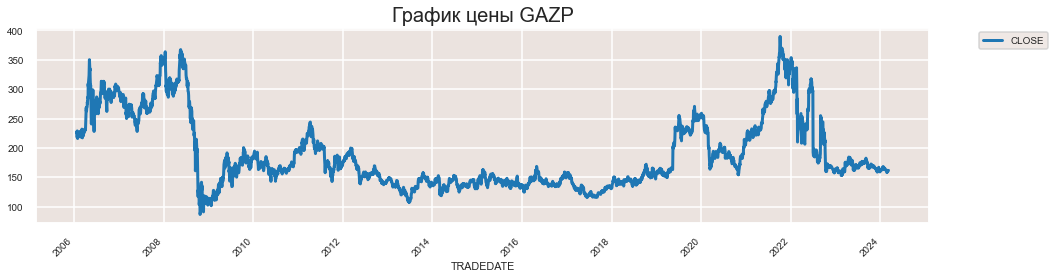

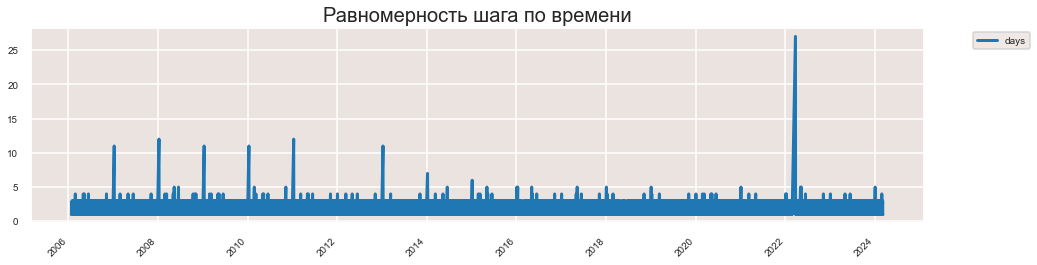

In [14]:
data = pd.read_pickle(f'../data/parsing/ticker_GAZP.pkl')
ts_first_view(data)

#### Выводы

- удалось извлечь исторические данные наблюдений цены по активам; 
- разные активы имеют разные временные интервалы наблюдений;
- временные интервалы имеют разрывы, что можно объяснить приостановкой торгов, а также праздниками и выходными, когда торги не проводились.

## 1.3 Парсинг истории финансовых показателей

Финансовые показатели по годам по данным отчетов MSFO компаний будем извлекать с ресурса:
- https://smart-lab.ru/

In [15]:
from io import StringIO
import pandas as pd
import requests
import csv

Подготовим функцию извлечения данных для конкретного тикера

In [16]:
def get_MSFO (TICKER):
    for i in range(3):
        try:
            CSV_URL = f'https://smart-lab.ru/q/{TICKER}/f/y/MSFO/download/'
            with requests.Session() as s:
                download = s.get(CSV_URL)
                
                try:
                    text=StringIO(download.content.decode('utf-8'))
                    df=pd.read_csv(text, sep=';')
                except:
                    line_iterator = (x.decode('utf-8') for x in download.iter_lines(decode_unicode=True))
                    cr = csv.reader(line_iterator, delimiter=';')
                    my_list = list(cr)
                    df=pd.DataFrame(my_list)
            break
        except:
            # Иначе, пробуем еще несколько раз, пока не закончатся попытки
            print(f'AHTUNG! parsing once again for {TICKER}: ')
            continue
        
        time.sleep(1)
    return df

Извлекаем данные по списку тикеров и сохраняем в отдельных файлах типа .pkl с пометкой '_raw'

Посмотрим на пример извлеченных данных:

In [17]:
data = pd.read_pickle(f'../data/parsing/raw/MSFO_SBER_raw.pkl')
data.head()

,Unnamed: 0,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,LTM
0,Дата отчета,NaN,NaN,NaN,NaN,NaN,NaN,30.10.2020,NaN,24.10.2019,17.04.2018,28.02.2019,27.02.2020,04.03.2021,02.03.2022,09.03.2023,28.02.2024,28.02.2024
1,Валюта отчета,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB,RUB
2,"Чистый операц доход, млрд руб",NaN,NaN,NaN,746.0,920.8,1 104,1 301,1 430,1 698,1 903,1 936,2 013,2 182,2 501,2 055,3 428,3 428
3,"Чист. проц. доходы, млрд руб",NaN,NaN,502.8,575.8,704.8,862.2,1 020,988.0,1 363,1 349,1 397,1 416,1 589,1 802,1 875,2 565,2 565
4,"Чист. комисс. доход, млрд руб",NaN,NaN,111.9,125.6,170.3,220.3,306.4,384.1,349.1,394.2,445.3,497.9,545.3,616.8,697.1,763.9,763.9


Очевидно необходима предобработка.

Подготовим соответствующие функции и сформируем список фин. показателей

In [18]:
def get_selection (df, select_list):
    df_local = df.copy()
    
    df_local = data[data['Unnamed: 0'].isin(select_list)]
    df_local.set_index(keys='Unnamed: 0', drop=True, inplace=True)
    #df_local.drop(index=['EV, млрд руб', 'EPS, руб'], inplace=True)
    df_local.index.name=''
        
    df_local.drop(columns='LTM', inplace=True, errors='ignore')
    
    return df_local

In [19]:
def do_farmation(x):
    if isinstance(x, str) == True :
        x = x.replace(' ', '')
        x = x.replace('%', '')
        x = float(x)
    return x

In [20]:
def get_formated_features(df):
    df_local = df.T.copy()
    for col in df_local.columns:
        df_local[col] = np.where(df_local[col].isnull(), np.nan, df_local[col])
        df_local[col] = df_local[col].apply(lambda x: do_farmation(x))
    
    df_local.columns = ['Див доход, ао, %', 'Дивиденды/прибыль, %', 'Чистая рентаб, %']
    return df_local

In [21]:
select_list = ['Див доход, ао, %',
               'Дивиденды/прибыль, %',
               'Чистая рентаб, %',
               'Рентабельность банка, %']

Проведем предобработку и сохраним в отдельных файлах формата .plk

In [22]:
for ticker in tqdm_notebook(tickers_list, desc='tickers', leave=False):
    try:
        data = pd.read_pickle(f'../data/parsing/raw/MSFO_{ticker}_raw.pkl')
        df_selected = get_selection(data, select_list)
        df_selected_formated = get_formated_features(df_selected)
        df_selected_formated.to_pickle(f'../data/parsing/MSFO_{ticker}.pkl')
    except:
        continue

tickers:   0%|          | 0/66 [00:00<?, ?it/s]

Посмотрим на результат предобработки:

In [23]:
for i in ['SBER', 'GAZP']:
    data = pd.read_pickle(f'../data/parsing/MSFO_{i}.pkl')
    print(f'____{i}____')
    display(data)

____SBER____


,"Див доход, ао, %","Дивиденды/прибыль, %","Чистая рентаб, %"
2008,2.1,0.0,NaN
2009,0.1,0.0,NaN
2010,0.9,0.0,NaN
2011,2.6,15.0,42.3
2012,2.8,16.0,37.8
2013,3.2,20.0,32.8
2014,0.8,4.0,22.3
2015,1.9,20.0,15.6
2016,3.5,25.0,31.9
2017,5.3,36.0,39.3


____GAZP____


,"Див доход, ао, %","Дивиденды/прибыль, %","Чистая рентаб, %"
2000,3.4,NaN,NaN
2001,2.0,NaN,NaN
2002,0.5,NaN,NaN
2003,0.9,NaN,NaN
2004,1.6,NaN,NaN
2005,1.4,NaN,NaN
2006,0.8,NaN,NaN
2007,0.8,17.0,20.3
2008,0.3,5.0,6.9
2009,1.3,6.0,32.4


#### Выводы

- удалось извлечь исторические данные финансовых показателей по компаниям; 
- разные активы имеют разные временные интервалы наблюдений - для дальнейшей работы необходимо выделить общий временной интервал;